In [2]:
from isaac_victor_envs.utils import get_assets_dir
from isaac_victor_envs.tasks.allegro import AllegroScrewdriverTurningEnv
# from isaac_victor_envs.tasks.allegro_ros import RosAllegroValveTurningEnv

import numpy as np
import pickle
from tqdm.notebook import tqdm

import torch
import time
import copy
import yaml
import pathlib
from functools import partial
import sys

import pytorch_volumetric as pv
import pytorch_kinematics as pk
import pytorch_kinematics.transforms as tf
from torch.func import vmap, jacrev, hessian, jacfwd
# import pytorch3d.transforms as tf

import matplotlib.pyplot as plt
from ccai.utils.allegro_utils import *
# from allegro_valve_roll import AllegroValveTurning, AllegroContactProblem, PositionControlConstrainedSVGDMPC, \
#    add_trajectories, add_trajectories_hardware

from ccai.allegro_contact import AllegroManipulationProblem, PositionControlConstrainedSVGDMPC, add_trajectories, \
    add_trajectories_hardware
from ccai.allegro_screwdriver_problem_diffusion import AllegroScrewdriverDiff
from scipy.spatial.transform import Rotation as R

# from ccai.mpc.ipopt import IpoptMPC
# from ccai.problem import IpoptProblem
from ccai.models.trajectory_samplers import TrajectorySampler

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

Importing module 'gym_38' (/home/abhinav/Downloads/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/abhinav/Downloads/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 2.3.1+cu118
Device count 1
/home/abhinav/Downloads/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/abhinav/.cache/torch_extensions/py38_cu118 as PyTorch extensions root...
Emitting ninja build file /home/abhinav/.cache/torch_extensions/py38_cu118/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
obj_dof = 3
# config = yaml.safe_load(pathlib.Path(f'../examples/config/{sys.argv[1]}.yaml').read_text())
config = yaml.safe_load(pathlib.Path(f'../examples/config/allegro_screwdriver_proj_diff_init.yaml').read_text())
config['visualize'] = False

if config['mode'] == 'hardware':
    env = RosAllegroValveTurningEnv(1, control_mode='joint_impedance',
                                    use_cartesian_controller=False,
                                    viewer=True,
                                    steps_per_action=60,
                                    friction_coefficient=1.0,
                                    device=config['sim_device'],
                                    valve=config['object_type'],
                                    video_save_path=img_save_dir,
                                    joint_stiffness=config['kp'],
                                    fingers=config['fingers'],
                                    )
else:
    if not config['visualize']:
        img_save_dir = None

    env = AllegroScrewdriverTurningEnv(1, control_mode='joint_impedance',
                                        use_cartesian_controller=False,
                                        viewer=config['visualize'],
                                        steps_per_action=60,
                                        friction_coefficient=config['friction_coefficient'] * 1.05,
                                        # friction_coefficient=1.0,  # DEBUG ONLY, set the friction very high
                                        device=config['sim_device'],
                                        video_save_path=img_save_dir,
                                        joint_stiffness=config['kp'],
                                        fingers=config['fingers'],
                                        )

sim, gym, viewer = env.get_sim()

state = env.get_state()
# try:
#     while True:
#         start = env.get_state()['q'][:, :-1]
#         env.step(start)
#         print('waiting for you to finish camera adjustment, ctrl-c when done')
#         time.sleep(0.1)
# except KeyboardInterrupt:
#     pass

sim_env = None
ros_copy_node = None
if config['mode'] == 'hardware':
    sim_env = env
    from hardware.hardware_env import HardwareEnv

    env = HardwareEnv(sim_env.default_dof_pos[:, :16], finger_list=['index', 'thumb'], kp=config['kp'])
    env.world_trans = sim_env.world_trans
    env.joint_stiffness = sim_env.joint_stiffness
    env.device = sim_env.device
    env.valve_pose = sim_env.valve_pose
elif config['mode'] == 'hardware_copy':
    from hardware.hardware_env import RosNode

    ros_copy_node = RosNode()

results = {}

# set up the kinematic chain
asset = f'{get_assets_dir()}/xela_models/allegro_hand_right.urdf'
ee_names = {
    'index': 'allegro_hand_hitosashi_finger_finger_0_aftc_base_link',
    'middle': 'allegro_hand_naka_finger_finger_1_aftc_base_link',
    'ring': 'allegro_hand_kusuri_finger_finger_2_aftc_base_link',
    'thumb': 'allegro_hand_oya_finger_3_aftc_base_link',
}
config['ee_names'] = ee_names
config['obj_dof'] = 3

screwdriver_asset = f'{get_assets_dir()}/screwdriver/screwdriver.urdf'

chain = pk.build_chain_from_urdf(open(asset).read())
screwdriver_chain = pk.build_chain_from_urdf(open(screwdriver_asset).read())
frame_indices = [chain.frame_to_idx[ee_names[finger]] for finger in config['fingers']]  # combined chain
frame_indices = torch.tensor(frame_indices)
state2ee_pos = partial(state2ee_pos, fingers=config['fingers'], chain=chain, frame_indices=frame_indices,
                        world_trans=env.world_trans)

forward_kinematics = partial(chain.forward_kinematics,
                                frame_indices=frame_indices)  # full_to= _partial_state = partial(full_to_partial_state, fingers=config['fingers'])
partial_to_full_state = partial(partial_to_full_state, fingers=config['fingers'])

controller = 'csvgd'
goal = - 0.5 * torch.tensor([0, 0, np.pi])
# set up params
params = config.copy()
params.pop('controllers')
params.update(config['controllers'][controller])
params['controller'] = controller
params['valve_goal'] = goal.to(device=params['device'])
params['chain'] = chain.to(device=params['device'])
object_location = torch.tensor([0, 0, 1.205]).to(
    params['device'])  # TODO: confirm if this is the correct location
params['object_location'] = object_location

num_fingers = len(params['fingers'])
state = env.get_state()
start = state['q'].reshape(4 * num_fingers + 4).to(device=params['device'])
if 'csvgd' in params['controller']:
    # index finger is used for stability
    if 'index' in params['fingers']:
        fingers = params['fingers']
    else:
        fingers = ['index'] + params['fingers']

pregrasp_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    regrasp_fingers=fingers,
    contact_fingers=[],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
)
# finger gate index
index_regrasp_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    regrasp_fingers=['index'],
    contact_fingers=['middle', 'thumb'],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
    default_dof_pos=env.default_dof_pos[:, :16]
)
thumb_and_middle_regrasp_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    contact_fingers=['index'],
    regrasp_fingers=['middle', 'thumb'],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
    default_dof_pos=env.default_dof_pos[:, :16]
)
turn_problem = AllegroScrewdriverDiff(
    start=start[:4 * num_fingers + obj_dof],
    goal=params['valve_goal'] * 0,
    T=params['T'],
    chain=params['chain'],
    device=params['device'],
    object_asset_pos=env.table_pose,
    object_location=params['object_location'],
    object_type=params['object_type'],
    world_trans=env.world_trans,
    contact_fingers=['index', 'middle', 'thumb'],
    obj_dof=obj_dof,
    obj_joint_dim=1,
    optimize_force=params['optimize_force'],
    default_dof_pos=env.default_dof_pos[:, :16]
)
contact_mode_dict = {0: 'pregrasp', 2: 'index', 1: 'thumb_middle', 3: 'turn'}
t = 15
# with open(data_path / f'constraint_violations.p', 'wb') as f:
#     pickle.dump(constraint_violations_all, f)


Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
Using VHACD cache directory '/home/abhinav/.isaacgym/vhacd'
Found existing convex decomposition for mesh '/home/abhinav/Documents/git_packages/isaacgym-arm-envs/isaac_victor_envs/assets/xela_models/mesh/allegro/base_ns.stl'
Found existing convex decomposition for mesh '/home/abhinav/Documents/git_packages/isaacgym-arm-envs/isaac_victor_envs/assets/xela_models/mesh/allegro/link_1.0.stl'
Found existing convex decomposition for mesh '/home/abhinav/Documents/git_packages/isaacgym-arm-envs/isaac_victor_envs/assets/xela_models/mesh/ft_c.stl'


In [34]:
data.keys()

dict_keys(['rand_init_csvto', 'diff_init_csvto', 'proj_diff_init_csvto', 'diff_init_csvto_presampled', 'proj_diff_init_csvto_presampled', 'proj_diff_init_csvto_presampled_guided', 'proj_diff_init_csvto_pre_sampled_high_noise', 'proj_diff_init_csvto_presampled_guided_high_noise', 'diff_init_csvto_presampled_high_noise'])

In [4]:
def calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits):
    if not torch.is_tensor(to_eval):
        to_eval = torch.tensor(to_eval).to(device=params['device'])
    else:
        to_eval = to_eval.to(device=params['device'])
    if c_state == 'pregrasp':
        # Call _con_eq and _con_ineq to get constraint violation
        prob = pregrasp_problem
        inds = torch.arange(27)

    elif c_state == 'index':
        prob = index_regrasp_problem
        # Need to rearrange (index, middle, thumb)
        if plans_or_inits == 'plans':
            inds = torch.cat((torch.arange(27), torch.arange(30, 36)))
        else:
            inds = torch.arange(33)

    elif c_state == 'thumb_middle':
        prob = thumb_and_middle_regrasp_problem
        inds = torch.arange(30)

    elif c_state == 'turn':
        prob = turn_problem
        inds = torch.arange(36)

    prob._preprocess(to_eval, projected_diffusion=False)
    g, _, _ = prob._con_eq(to_eval[..., inds], compute_grads=False, compute_hess=False, verbose=True, projected_diffusion=False)
    h, _, _ = prob._con_ineq(to_eval[..., inds], compute_grads=False, compute_hess=False, verbose=True, projected_diffusion=False)
    if g is not None:
        g = g.cpu()
    if h is not None:
        h = h.cpu()

    info = {'g': g, 'h': h, 'c_state': c_state}
    info_list.append(info)
    return info_list

def gen_constraint_data(plans_or_inits, constraint_violations, path, traj_data=[None]*10):
    for trial in tqdm(range(1, 11)):
        info_list = []
        if traj_data[trial-1] is None:
            try:
                with open(path + f'/trial_{trial}/traj_data.p', 'rb') as f:
                    data = pickle.load(f)
            except:
                continue
        else:
            data = traj_data[trial-1]
        if plans_or_inits == 'plans':
            data[t]['plans'] = torch.tensor(data[t]['plans']).to(device=params['device'])
            loop_range = data[t]['plans'].shape[0]
        elif plans_or_inits == 'optimizer_paths':
            loop_range = len(data[t]['optimizer_paths'])
        else:
            loop_range = len(data[t]['inits'])
        for i in (range(loop_range)):
            c_state = contact_mode_dict[data[t]['contact_state'][i].sum().item()]
            to_eval = data[t][plans_or_inits][i]
            # if plans_or_inits == 'optimizer_paths':
            #     to_eval = to_eval[0].flatten(0, 1)
            # info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
            if plans_or_inits in {'plans', 'inits', 'traj'}:
                info_list = calc_info(c_state, to_eval, info_list, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
            else:
                to_eval = to_eval[0]
                all_infos = []
                for csvto_tstep in (range(data[t]['optimizer_paths'][i][0].shape[0])):
                    all_infos = calc_info(c_state, to_eval[csvto_tstep], all_infos, pregrasp_problem, index_regrasp_problem, thumb_and_middle_regrasp_problem, turn_problem, plans_or_inits)
                info_list.append(all_infos)
        constraint_violations.append(info_list)

In [5]:
def get_traj(name):
    path = f'/home/abhinav/Documents/ccai/data/experiments/{name}/csvgd'

    all_data = []
    all_x = []
    # all_d2goal = []
    all_traj_data = []
    for trial_num in range(1, 11):
        # print(path + f'/trial_{trial_num}/trajectory.npz')
        # if 'rand' in name or 'proj' in name or 'diff' in name:
        with open(path + f'/trial_{trial_num}/trajectory.pkl', 'rb') as data:
            d = pickle.load(data)
            traj = np.stack((d[:-1]), axis=0)
            # end = d[-1].reshape(1, -1)
            # end = np.concatenate((end, np.zeros((1, 21))), axis=1)
            # traj = np.concatenate((traj, end), axis=0)
        # else:
        #     d = np.load(path + f'/trial_{trial_num}/trajectory.npz')
        #     end_state = d['x'] 
        with open(path + f'/trial_{trial_num}/traj_data.p', 'rb') as f:
            traj_data = pickle.load(f)
            for key in traj_data.keys():
                if torch.is_tensor(traj_data[key]):
                    traj_data[key] = traj_data[key].cpu().numpy()
            # all_d2goal.append(d2goal)
            # if 'rand' not in name and 'proj' not in name and 'diff' not in name::
            #     traj = traj_data[15]['plans'][:, 0]

                # end = np.concatenate((end_state, np.zeros((1, 21))), axis=1)
                # traj = np.concatenate((traj, end), axis=0)
            traj_data[15]['traj'] = np.expand_dims(traj, axis=1)
            all_traj_data.append(traj_data)  
            all_data.append(traj_data)
            
    constraint_violations_all = {
        # 'optimizer_paths': [],
        'traj': [],
        'inits': [],
        'plans': [],

    }
    for plans_or_inits in constraint_violations_all.keys():
        if plans_or_inits == 'traj':
            gen_constraint_data(plans_or_inits, constraint_violations_all[plans_or_inits], path, traj_data=all_traj_data)
        else:
            gen_constraint_data(plans_or_inits, constraint_violations_all[plans_or_inits], path)

    # Take the list of dicts and turn it into a dict of lists
    all_data = {k: [d[k] for d in all_data] for k in all_data[0]}
    all_data['violation'] = constraint_violations_all

    return all_x, all_data#, all_d2goal

In [6]:
# data = {}
with open('./saved_eval.pkl', 'rb') as f:
    data = pickle.load(f)
# for key, name in [('rand_init_csvto', 'allegro_screwdriver_random_init_no_guidance_actual_random'), ('diff_init_csvto', 'allegro_screwdriver_diffusion_init_no_guidance_retry'), ('proj_diff_init_csvto', 'allegro_screwdriver_projected_diffusion_init_no_guidance')]:
# for key, name in [('proj_diff_init_csvto_presampled', 'allegro_screwdriver_projected_diffusion_init_no_guidance_pre_sampled'), ('proj_diff_init_csvto_presampled_guided', 'allegro_screwdriver_projected_diffusion_init_guidance_pre_sampled'), ('proj_diff_init_csvto_pre_sampled_high_noise', 'allegro_screwdriver_projected_diffusion_init_no_guidance_pre_sampled_high_sample_noise')]:
# for key, name in [('proj_diff_init_csvto_presampled_guided_high_noise', 'allegro_screwdriver_projected_diffusion_init_guidance_pre_sampled_high_sample_noise'), ('diff_init_csvto_presampled_high_noise', 'allegro_screwdriver_diffusion_init_no_guidance_pre_sampled_high_sample_noise')]:
    
for key, name in []:
    print(key)
    data[key] = {}
    all_x, all_data = get_traj(name)
    # data[key]['x'] = {
    #     'raw': all_x,
    #     'mean': np.mean(all_x, axis=0),
    #     'std': np.std(all_x, axis=0),
    # }
    data[key] = {**data[key], **all_data}
    # data[key]['d2goal'] = {
    #     'raw': all_d2goal,
    #     'mean': np.mean(all_d2goal, axis=0),
    #     'std': np.std(all_d2goal, axis=0),
    # }

with open('./saved_eval.pkl', 'wb') as f:
    pickle.dump(data, f)

In [7]:
def gen_opt_path_violation_plot(data, keys):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    # violation_by_mode_g = {
    #     key: [] for key in keys
    # }

    # violation_by_mode_h = {
    #     key: [] for key in keys
    # }
    for key in keys:
        print(key)
        g_all = []

        constraint_violations = data[key]['violation']['optimizer_paths']
        # h_all = []
        for trial_ind in range(len(constraint_violations)):
            g_trial_ind = []
            # h_trial_ind = []
            for contact_mode_seq in constraint_violations[trial_ind]:
                opt_path_g = []
                for csvto_tstep in range(len(contact_mode_seq)):
                    g = torch.abs(contact_mode_seq[csvto_tstep]['g']).mean().cpu().item()
                    # h = torch.relu(contact_mode_seq['h']).mean().cpu().item()
                    opt_path_g.append(g)
                    # h_trial_ind.append(h)
                g_trial_ind.append(opt_path_g)
            g_all.append(g_trial_ind)
            # h_all.append(h_trial_ind)
        g_all = np.stack(g_all, axis=0).reshape(len(constraint_violations), -1)
        # h_all = np.stack(h_all, axis=0)
        g_all_mean = g_all.mean(axis=0)
        # h_all_mean = h_all.mean(axis=0)
        g_all_std = g_all.std(axis=0)
        # h_all_std = h_all.std(axis=0)
                # mode = contact_mode_seq['c_state']

                # violation_by_mode_g[mode].append(contact_mode_seq['g'])
                # violation_by_mode_h[mode].append(contact_mode_seq['h'])


        # plot g_all_mean with error bars
        ax.plot(g_all_mean, label=key)
        ax.fill_between(np.arange(g_all_mean.shape[0]), g_all_mean - g_all_std, g_all_mean + g_all_std, alpha=0.5)
    # ax.plot(h_all_mean, label='h_all_mean')
    # ax.fill_between(np.arange(h_all_mean.shape[0]), h_all_mean - h_all_std, h_all_mean + h_all_std, alpha=0.5)
    ax.legend()
    ax.set_xlabel('CSVTO Step')
    ax.set_ylabel('Constraint Violation')

    plt.title(f'Optimizer Path Constraint Violation (Contact and Kinematics)')
    plt.show()

In [28]:
len(data['diff_init_csvto'][1])

10

In [25]:
(data['diff_init_csvto'][1][0])['plans'].shape

(11, 16, 1, 36)

rand_init_csvto
diff_init_csvto
proj_diff_init_csvto
diff_init_csvto_presampled


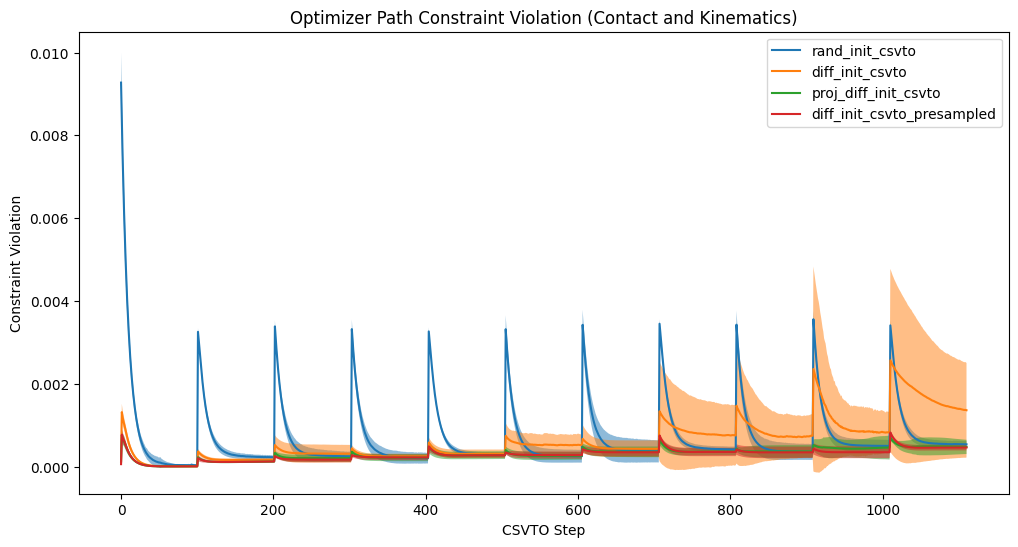

In [9]:
keys = ['rand_init_csvto', 'diff_init_csvto', 'proj_diff_init_csvto', 'diff_init_csvto_presampled']
gen_opt_path_violation_plot(data, keys)

In [36]:
def gen_plot(constraint_violations_all, keys, plans_or_inits):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    for key in keys:
        plan_cv = constraint_violations_all[key]['violation'][plans_or_inits]
        keys = ['pregrasp', 'index', 'thumb_middle', 'turn']
        # violation_by_mode_g = {
        #     key: [] for key in keys
        # }

        # violation_by_mode_h = {
        #     key: [] for key in keys
        # }
        g_all = []
        # h_all = []
        for trial_ind in range(len(plan_cv)):
            g_trial_ind = []
            # h_trial_ind = []
            for contact_mode_seq in plan_cv[trial_ind]:
                g = torch.abs(contact_mode_seq['g']).mean().cpu().item()
                # h = torch.relu(contact_mode_seq['h']).mean().cpu().item()
                g_trial_ind.append(g)
                # h_trial_ind.append(h)
            g_all.append(g_trial_ind)
            # h_all.append(h_trial_ind)
        g_all = np.stack(g_all, axis=0)
        # h_all = np.stack(h_all, axis=0)
        g_all_mean = g_all.mean(axis=0)
        # h_all_mean = h_all.mean(axis=0)
        g_all_std = g_all.std(axis=0)
        # h_all_std = h_all.std(axis=0)
                # mode = contact_mode_seq['c_state']

                # violation_by_mode_g[mode].append(contact_mode_seq['g'])
                # violation_by_mode_h[mode].append(contact_mode_seq['h'])


        # plot g_all_mean with error bars
        ax.plot(g_all_mean, label=key)
        ax.fill_between(np.arange(g_all_mean.shape[0]), g_all_mean - g_all_std, g_all_mean + g_all_std, alpha=0.5)
    # ax.plot(h_all_mean, label='h_all_mean')
    # ax.fill_between(np.arange(h_all_mean.shape[0]), h_all_mean - h_all_std, h_all_mean + h_all_std, alpha=0.5)
    ax.legend()
    ax.set_xlabel('Contact Mode Index')
    ax.set_ylabel('Constraint Violation')

    plt.title(f'{plans_or_inits} Constraint Violation (Contact and Kinematics)')
    plt.show()
    # plt.savefig(f'/home/abhinav/Pictures/constraint_violation_analysis/{random_or_diffusion}_init_{key}.png')

    # 4 columns, 2 rows subplots
    # fig, axs = plt.subplots(2, 4, figsize=(12, 12))

    # for ind in range(4):
    #     key = keys[ind]
    #     print(violation_by_mode_g[key])
    #     this_mode_g = torch.abs(violation_by_mode_g[key][t])
    #     print(this_mode_g.shape)

    #     this_mode_h = torch.relu(violation_by_mode_h[key][t])
    #     print(this_mode_h.shape)

In [70]:
dofs = {
    'roll': -3,
    'pitch': -2,
    'yaw': -1
}

def gen_plot_screwdriver_angle(data, keys, plans_or_inits, dof_to_plot='yaw'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    for key in keys:
        traj_all = []
        for trial_ind in range(len(data[key][15])):
            if plans_or_inits == 'traj':
                traj = data[key][15][trial_ind][plans_or_inits].reshape(-1, 36)[:, :15]
                traj_all.append(traj)
            else:
                traj = torch.stack([i[..., :15] for i in data[key][15][trial_ind][plans_or_inits]], axis=1).flatten(1, 2)
                traj = traj.cpu()
                for i in range(traj.shape[0]):
                    traj_all.append(traj[i])
        traj_all = np.stack(traj_all, axis=0)
        traj_all_mean = traj_all.mean(axis=0)[:, dofs[dof_to_plot]]
        traj_all_std = traj_all.std(axis=0)[:, dofs[dof_to_plot]]
        ax.plot(traj_all_mean, label=key)
        ax.fill_between(np.arange(traj_all_mean.shape[0]), traj_all_mean - traj_all_std, traj_all_mean + traj_all_std, alpha=0.5)
    ax.legend()
    ax.set_xlabel('Timestep')
    ax.set_ylabel(f'Screwdriver {dof_to_plot} Angle (rad)')
    plt.title(f'{plans_or_inits} Screwdriver {dof_to_plot} Angle')
    plt.show()

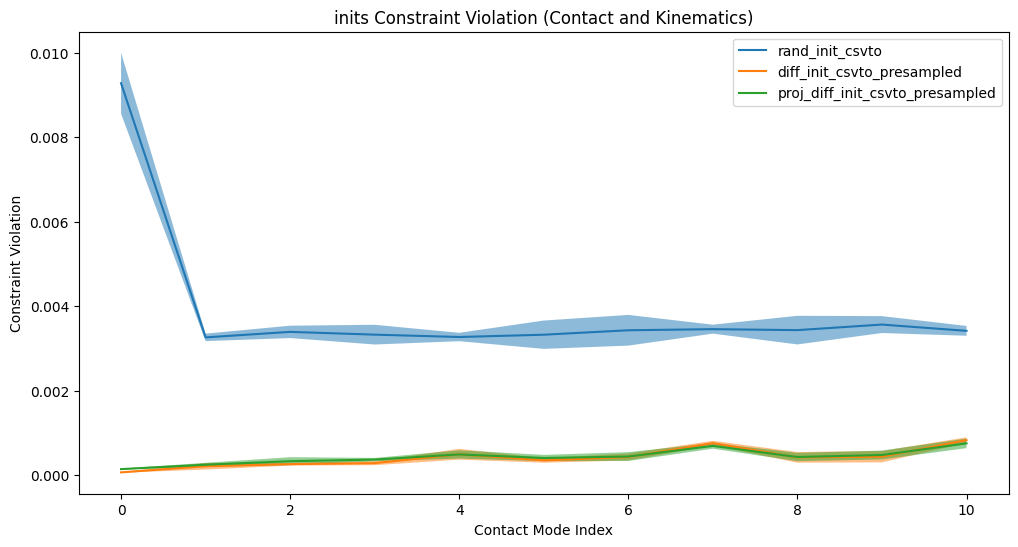

In [64]:
keys = ['rand_init_csvto', 'diff_init_csvto_presampled', 'proj_diff_init_csvto_presampled']

gen_plot(data, keys, 'inits')

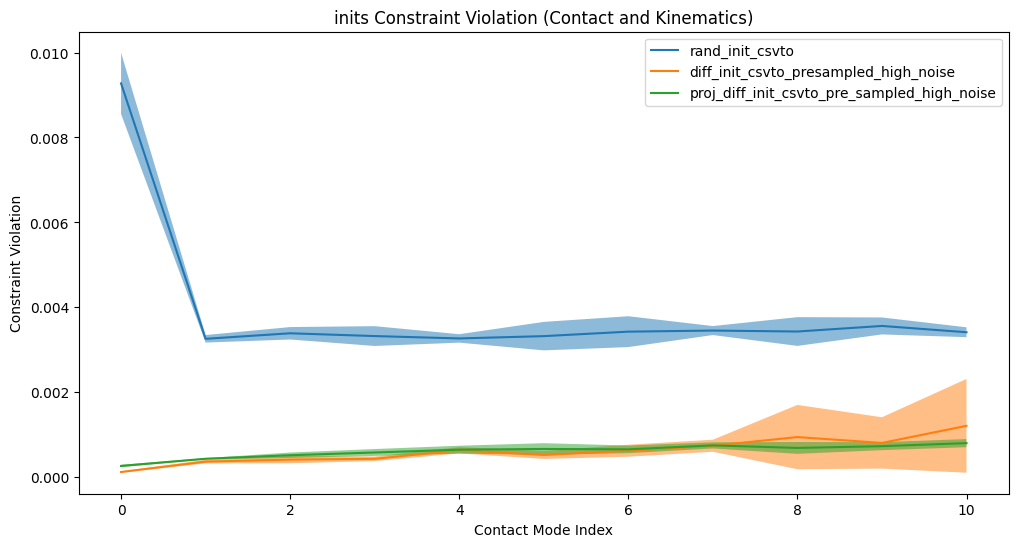

In [65]:
keys_ = ['rand_init_csvto', 'diff_init_csvto_presampled_high_noise', 'proj_diff_init_csvto_pre_sampled_high_noise']

gen_plot(data, keys_, 'inits')

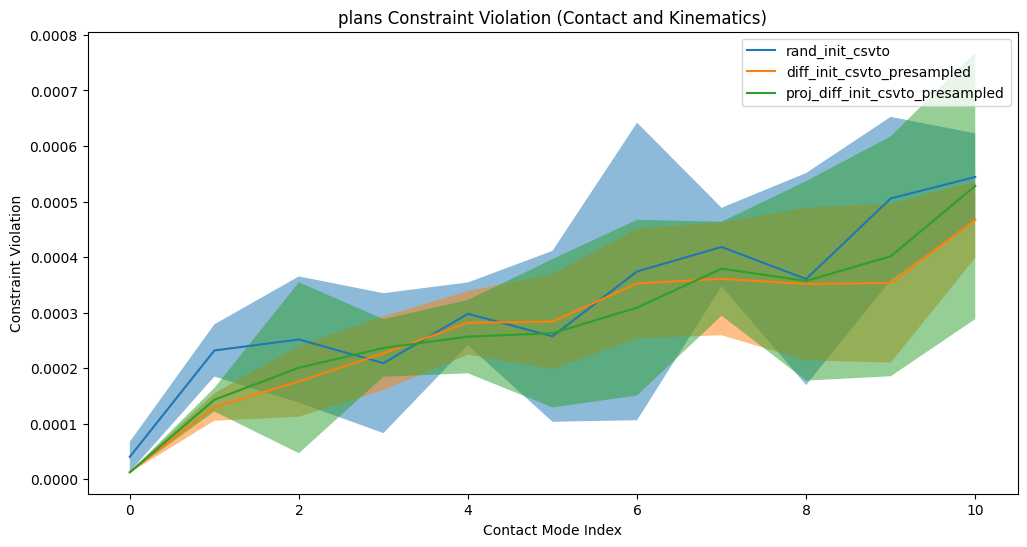

In [66]:
gen_plot(data, keys, 'plans')

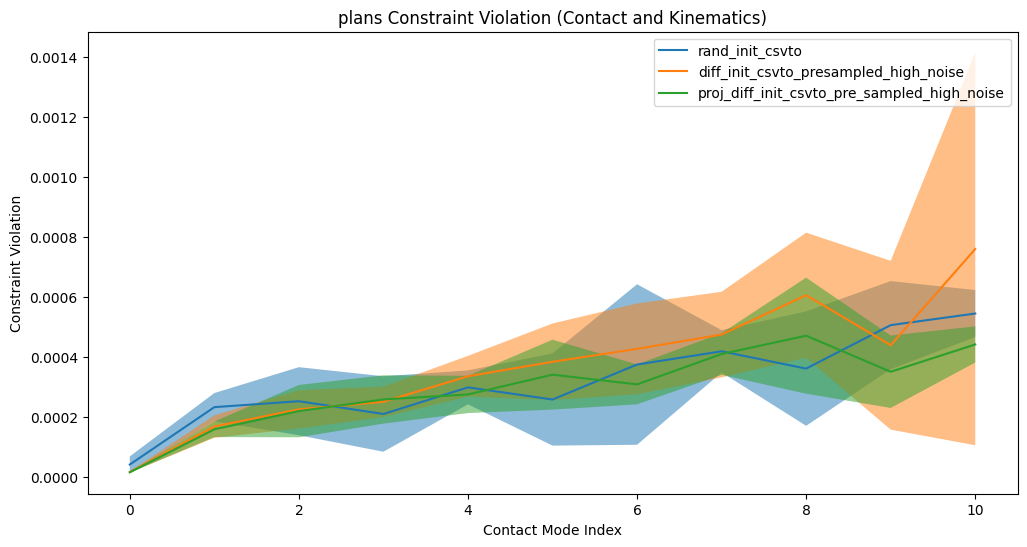

In [67]:
gen_plot(data, keys_, 'plans')

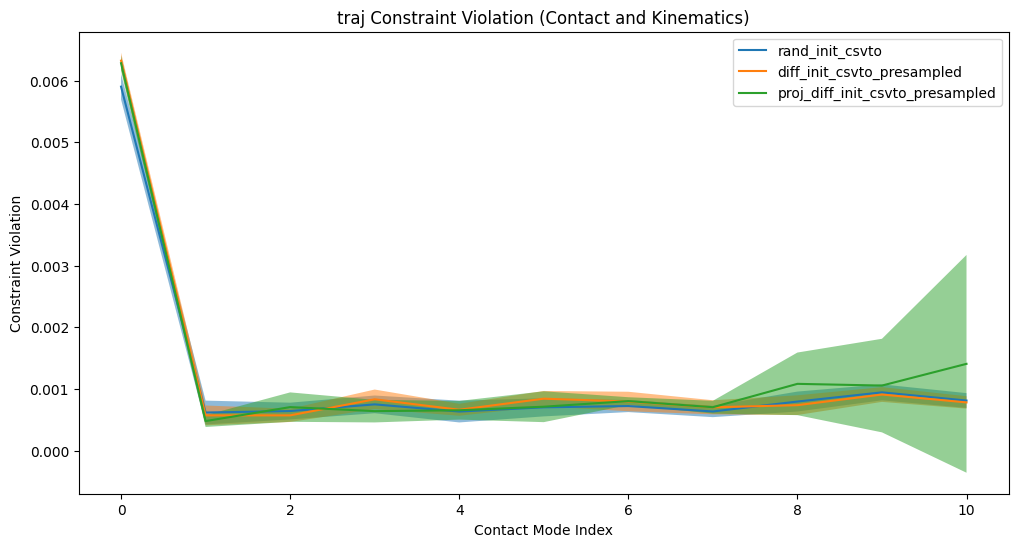

In [68]:
gen_plot(data, keys, 'traj')

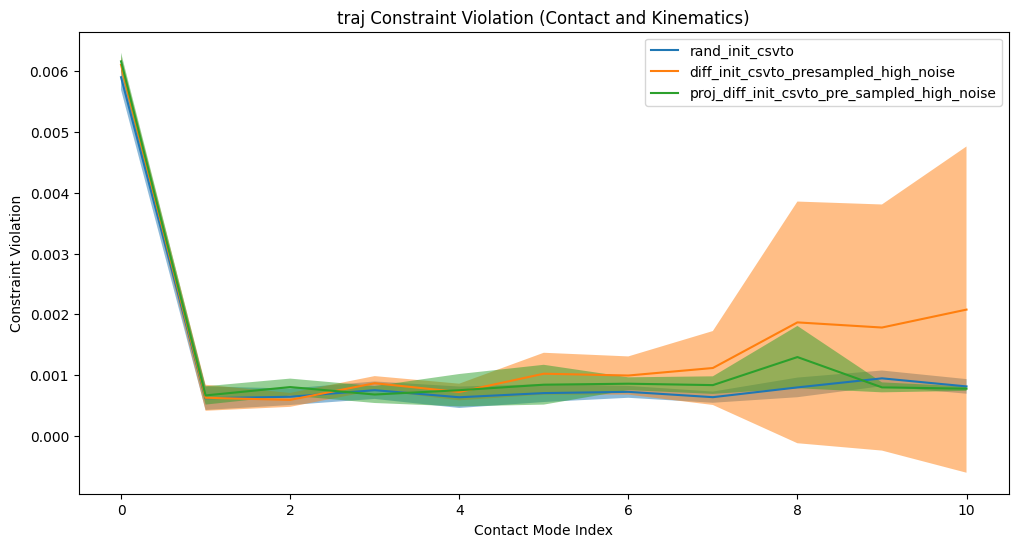

In [69]:
gen_plot(data, keys_, 'traj')

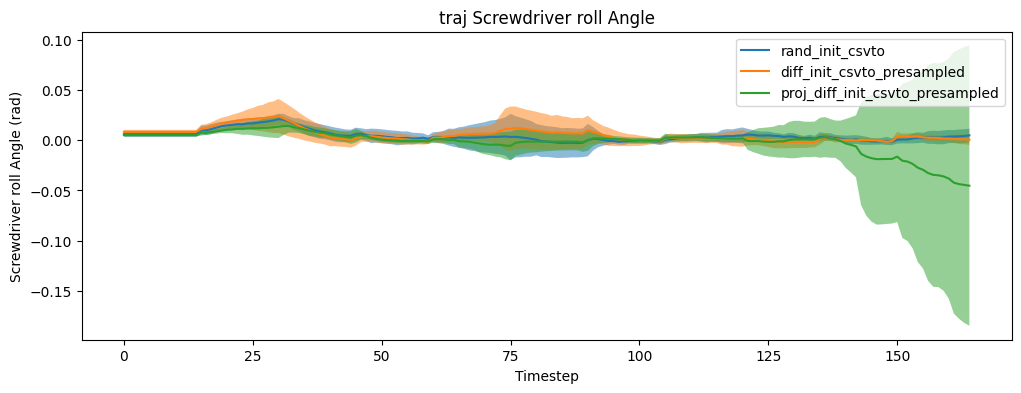

In [71]:
gen_plot_screwdriver_angle(data, keys, 'traj', dof_to_plot='roll')

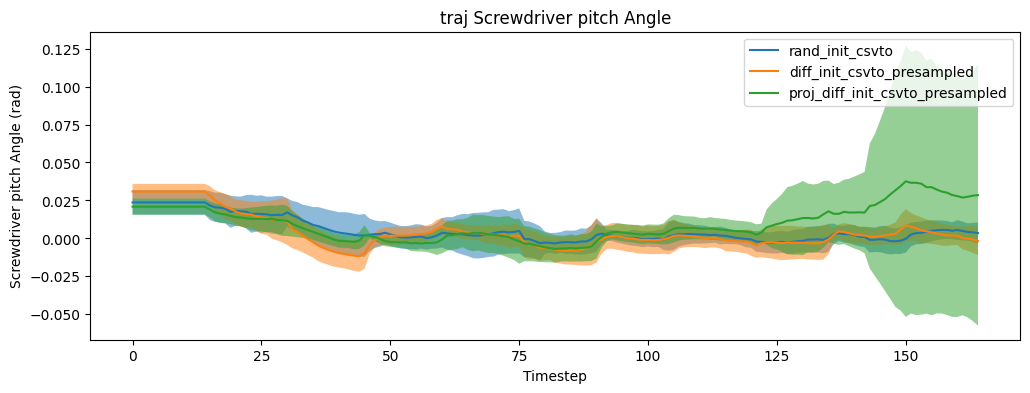

In [72]:
gen_plot_screwdriver_angle(data, keys, 'traj', dof_to_plot='pitch')

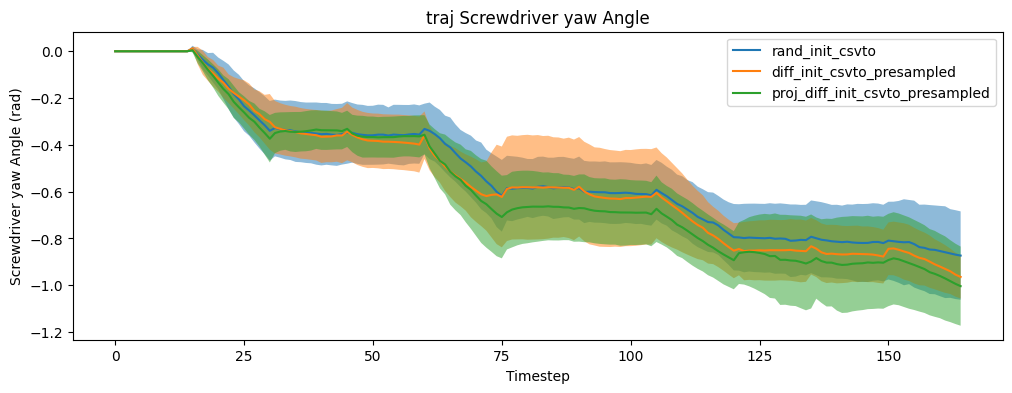

In [73]:
gen_plot_screwdriver_angle(data, keys, 'traj', dof_to_plot='yaw')

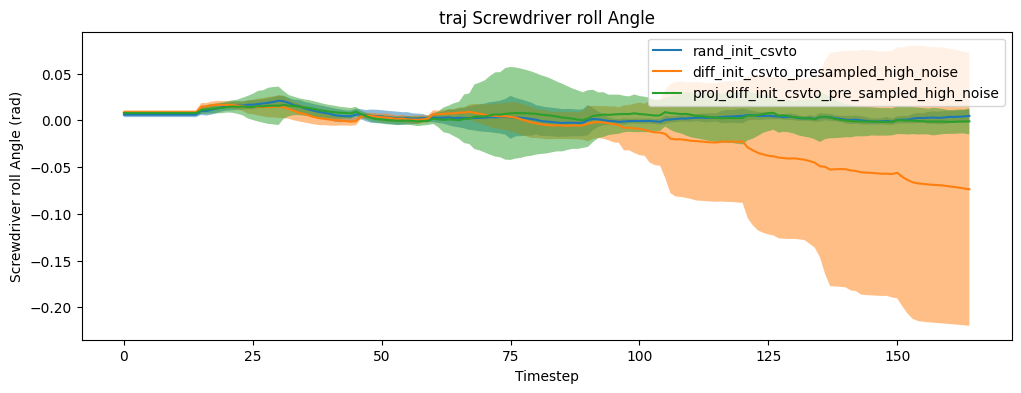

In [74]:
gen_plot_screwdriver_angle(data, keys_, 'traj', dof_to_plot='roll')

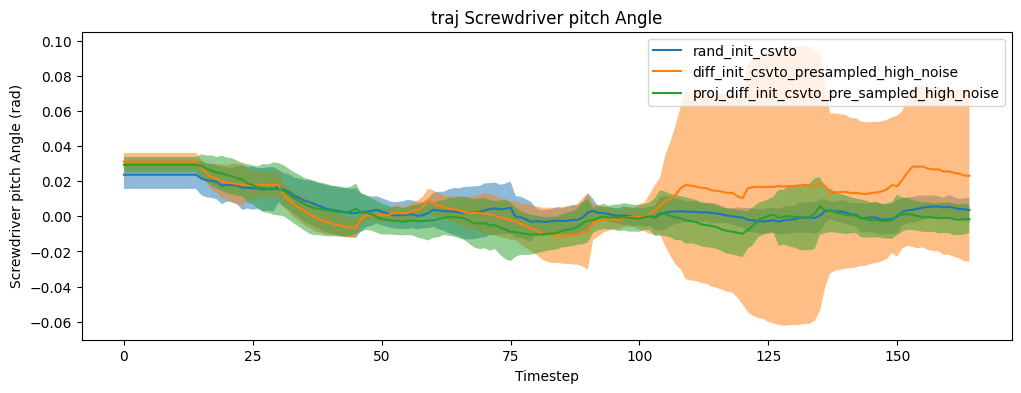

In [75]:
gen_plot_screwdriver_angle(data, keys_, 'traj', dof_to_plot='pitch')

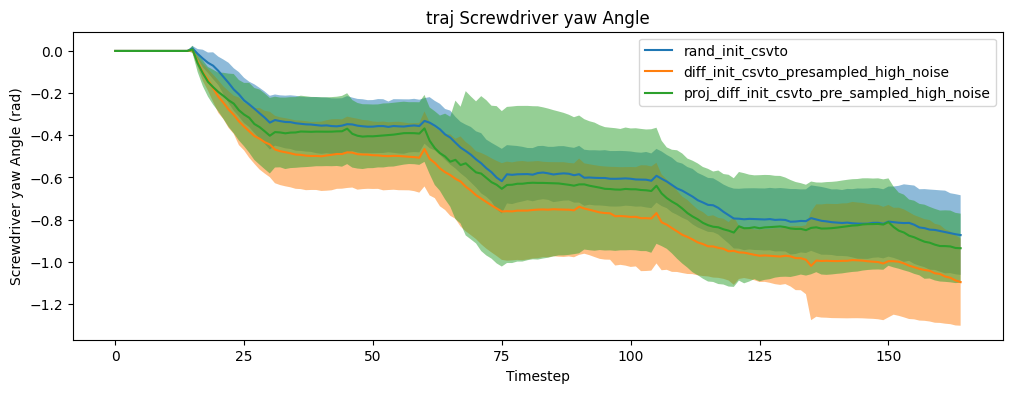

In [76]:
gen_plot_screwdriver_angle(data, keys_, 'traj', dof_to_plot='yaw')

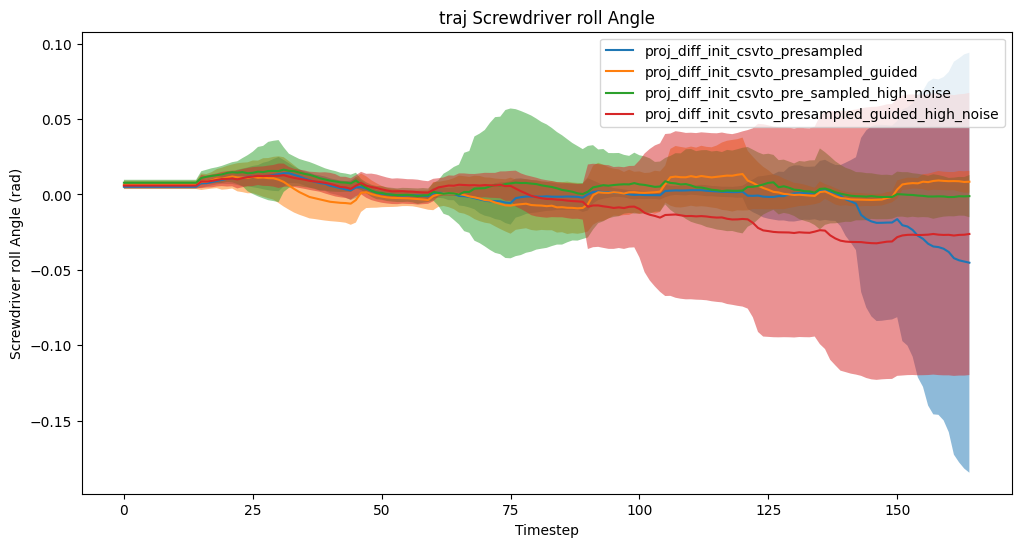

In [61]:
keys_g_ng = ['proj_diff_init_csvto_presampled', 'proj_diff_init_csvto_presampled_guided', 'proj_diff_init_csvto_pre_sampled_high_noise', 'proj_diff_init_csvto_presampled_guided_high_noise']

gen_plot_screwdriver_angle(data, keys_g_ng, 'traj', dof_to_plot='roll')


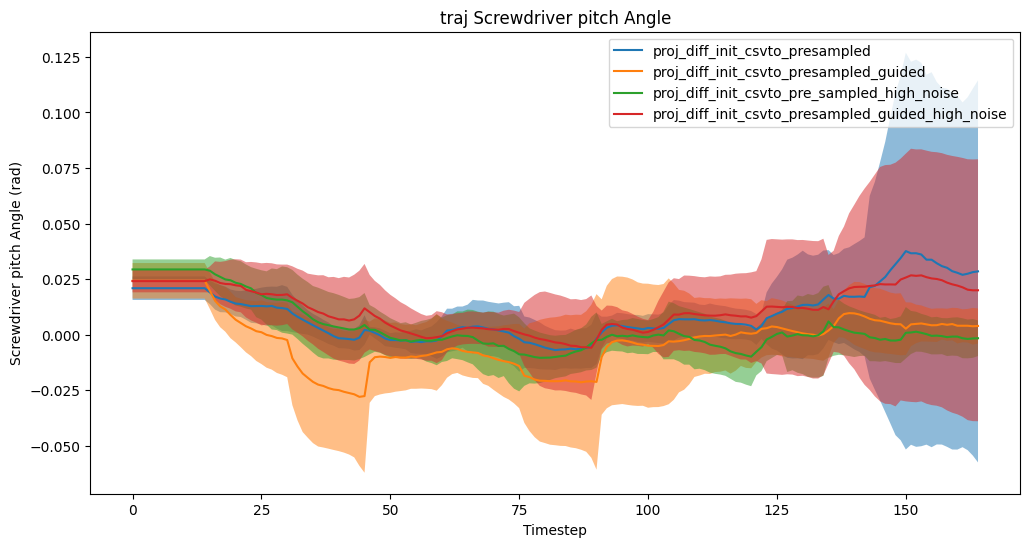

In [62]:
gen_plot_screwdriver_angle(data, keys_g_ng, 'traj', dof_to_plot='pitch')


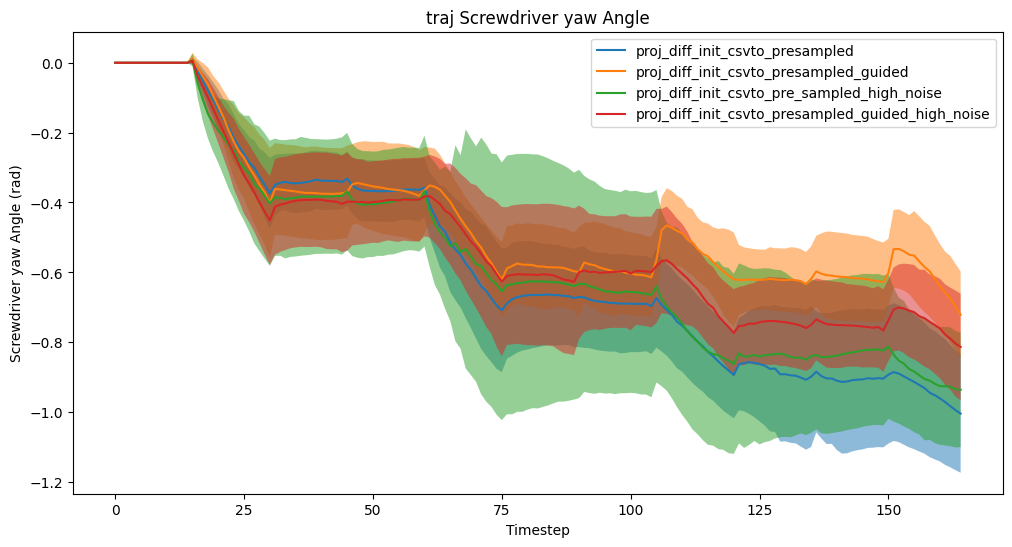

In [63]:
gen_plot_screwdriver_angle(data, keys_g_ng, 'traj', dof_to_plot='yaw')


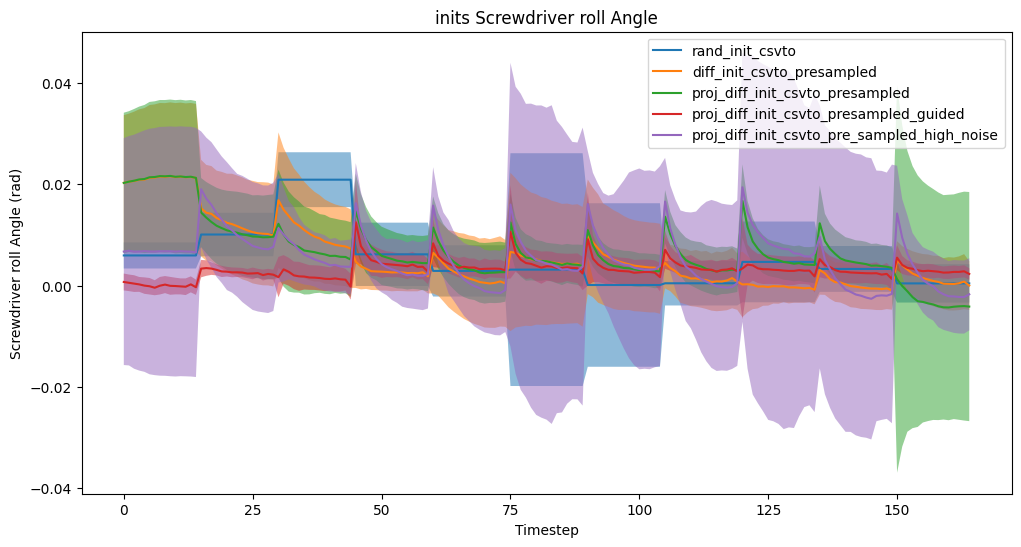

In [30]:
gen_plot_screwdriver_angle(data, keys, 'inits', dof_to_plot='roll')

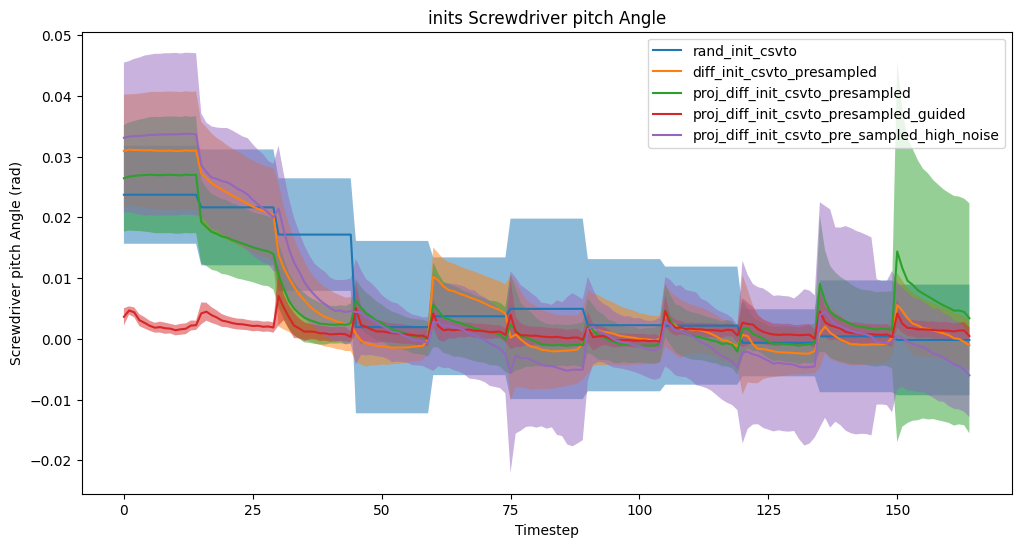

In [31]:
gen_plot_screwdriver_angle(data, keys, 'inits', dof_to_plot='pitch')

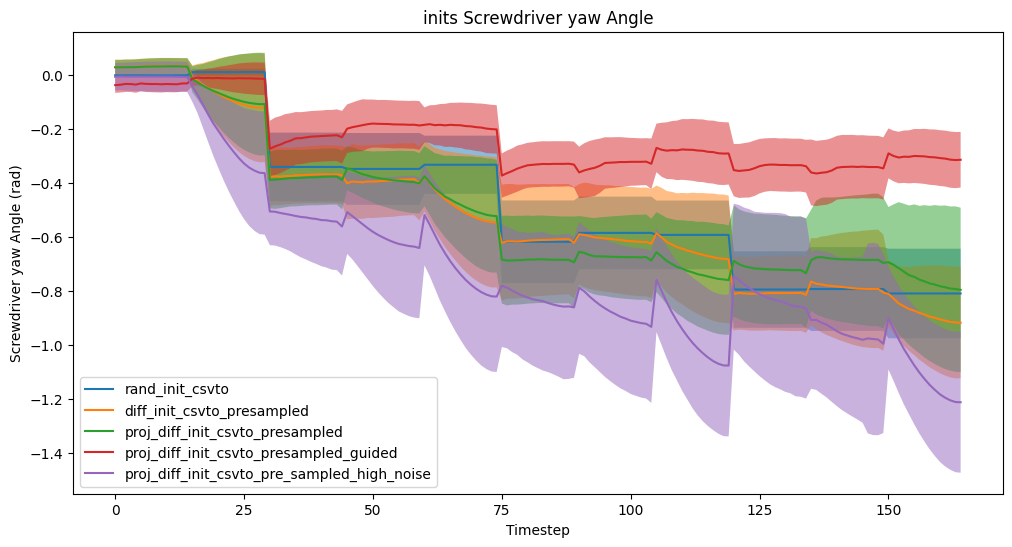

In [32]:
gen_plot_screwdriver_angle(data, keys, 'inits', dof_to_plot='yaw')